In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the datasets
original_sales_data = pd.read_csv('../data/snp_dld_2024_transactions.csv', low_memory=False)
original_rentals_data = pd.read_csv('../data/snp_dld_2024_rents.csv', low_memory=False)

In [31]:
meta_dup_sales = [
    'transaction_number',  # ID column
    'entry_id',            # Metadata
    'meta_ts',             # Metadata timestamp
    'master_project_en',   # Very few non-null values
    'master_project_ar',   # Very few non-null values
    'property_type_ar',    # Duplicate of property_type_en
    'property_subtype_ar', # Duplicate of property_subtype_en
    'project_name_ar',     # Duplicate of project_name_en
    'area_ar',             # Duplicate of area_en
    'nearest_landmark_ar', # Duplicate of nearest_landmark_en
    'nearest_metro_ar',    # Duplicate of nearest_metro_en
    'nearest_mall_ar',      # Duplicate of nearest_mall_en
    'parcel_id',  # not needed
    'transaction_type_en', #Duplicate of transaction_type_id
    'transaction_subtype_en', #Constant
    'transaction_subtype_id', #Constant
    'property_id', #Constant
    'property_type_id', #Constant
    'property_subtype_id', #Constant
    'building_age', #Constant
    'area_id', #Constant
    'is_freehold_text', #duplicate of is_freehold
    'property_usage_en' # Duplicate of property_usage_id
]
meta_dup_rentals=[
    'ejari_contract_number', # ID column
    'land_property_id',      # Redundant ID column
    'entry_id',              # Metadata
    'meta_ts',               # Metadata timestamp
    'master_project_en',     # Very few non-null values
    'master_project_ar',     # Very few non-null values
    'property_type_ar',      # Duplicate of property_type_en
    'property_subtype_ar',   # Duplicate of property_subtype_en
    'property_usage_ar',     # Duplicate of property_usage_en
    'project_name_ar',       # Duplicate of project_name_en
    'area_ar',               # Duplicate of area_en
    'nearest_landmark_ar',   # Duplicate of nearest_landmark_en
    'nearest_metro_ar',      # Duplicate of nearest_metro_en
    'nearest_mall_ar',        # Duplicate of nearest_mall_en
    'property_id',   #constant
    'property_usage_id', #constant
    'area_id',   #constant
    'ejari_property_type_id',   #constant
    'ejari_property_sub_type_id',  #constant
    'parking', #97% missing data
    'parcel_id', # negative correlation
    'is_freehold_text', # duplicate of is_freehold
    'rooms' # 97% missing

]
drop_after_missing_sales = [
    'transaction_datetime_year',  #Constant after handling dates
    'req_from_year',  #Constant after handling dates
    'req_from_day',  #Constant after handling dates
    'req_to_year', #Constant after handling dates
    'parking', # Replaced with parking count
    'rooms_en', # replaced with rooms_numeric
    'rooms_ar'
]

# List of columns to drop from rentals_data
drop_after_missing_rentals = [

    'registration_date_year',  #Constant after handling dates
    'req_from_year',  #Constant after handling dates
    'req_from_day',  #Constant after handling dates
    'req_to_year',  #Constant after handling dates
    'req_from_year',  #Constant after handling dates
    'req_from_day', #Constant after handling dates
    'req_to_year',  #Constant after handling dates
    'registration_date_year',  #Constant after handling dates
    'req_from_year',  #Constant after handling dates
    'req_from_day',  #Constant after handling dates
    'req_to_year', #Constant after handling dates
]

In [4]:
def process_date_columns(df, date_columns):
    for col in date_columns:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors='coerce')
            df[f"{col}_year"] = df[col].dt.year
            df[f"{col}_month"] = df[col].dt.month
            df[f"{col}_day"] = df[col].dt.day
            df[f"{col}_weekday"] = df[col].dt.weekday
            df[f"{col}_dayofyear"] = df[col].dt.dayofyear
    df.drop(columns=date_columns, inplace=True, errors='ignore')
    return df

sales_date_columns = ['transaction_datetime', 'req_from', 'req_to']
rentals_date_columns = ['registration_date', 'contract_start_date', 'contract_end_date', 'req_from', 'req_to']
sales_data = process_date_columns(original_sales_data, sales_date_columns)
rentals_data = process_date_columns(original_rentals_data, rentals_date_columns)

In [5]:
import re
import pandas as pd

def calculate_parking_count(value):
    """
    Calculate the parking count based on the given strategy:
    - Fields separated by commas are counted as separate spots unless 'to' is present.
    - If 'to' is present, calculate the range of parking spots.
    - Single identifiers like 'G-127' are counted as one spot.
    """
    if pd.isna(value):
        return 0  # No information

    total_count = 0
    fields = str(value).split(",")  # Split by commas
    for field in fields:
        field = field.strip()  # Remove extra whitespace
        if re.search(r"\bto\b", field, re.IGNORECASE):  # Check for 'to' (case insensitive)
            # Extract numbers in the range and calculate spots
            numbers = [int(num) for num in re.findall(r"\d+", field)]
            if len(numbers) == 2:  # Range is valid
                total_count += abs(numbers[1] - numbers[0]) + 1
        elif re.search(r"\d+", field):  # Single numeric identifier (e.g., G-127)
            total_count += 1
        else:
            total_count += 0  # Invalid or non-informative field
    return total_count

# Apply the logic to the `parking` column
sales_data['parking_count'] = sales_data['parking'].apply(calculate_parking_count)

# Save results for validation
sales_data[['parking', 'parking_count']].to_csv("processed_parking_count.csv", index=False)

# Example check
print(sales_data[['parking', 'parking_count']].tail())

       parking  parking_count
162801  B2-081              1
162802     NaN              0
162803  B2-140              1
162804   G-114              1
162805   G-127              1


In [6]:

# Display the number and percentage of missing values for Sales Data
print("Missing Values in Sales Data:")
missing_sales = sales_data.isnull().sum().to_frame(name="Missing Count")
missing_sales["Percentage"] = (missing_sales["Missing Count"] / len(sales_data)) * 100
print(missing_sales[missing_sales["Missing Count"] > 0])

# Display the number and percentage of missing values for Rentals Data
print("\nMissing Values in Rentals Data:")
missing_rentals = rentals_data.isnull().sum().to_frame(name="Missing Count")
missing_rentals["Percentage"] = (missing_rentals["Missing Count"] / len(rentals_data)) * 100
print(missing_rentals[missing_rentals["Missing Count"] > 0])

Missing Values in Sales Data:
                      Missing Count  Percentage
transaction_size_sqm            660    0.405390
parcel_id                    102355   62.869305
is_freehold                     684    0.420132
property_subtype_en            1392    0.855005
property_subtype_ar            1392    0.855005
rooms_en                      23257   14.285100
rooms_ar                      21362   13.121138
parking                       40463   24.853507
project_name_en               24760   15.208285
project_name_ar               24760   15.208285
nearest_landmark_en           47412   29.121777
nearest_landmark_ar           47412   29.121777
nearest_metro_en              65982   40.527990
nearest_metro_ar              65982   40.527990
nearest_mall_en               66842   41.056226
nearest_mall_ar               66842   41.056226
master_project_en            162460   99.787477
master_project_ar            162460   99.787477

Missing Values in Rentals Data:
                     Miss

## Handling small percentage of missing values

In [7]:
small_missing_sales = ['transaction_size_sqm', 'is_freehold', 'property_subtype_en'] 
sales_data[small_missing_sales].head()

,transaction_size_sqm,is_freehold,property_subtype_en
0,66.47,t,Flat
1,70.76,t,Flat
2,115.33,f,Flat
3,110.02,t,Flat
4,73.32,t,Flat


In [8]:
sales_data['is_freehold'].unique()

array(['t', 'f', nan], dtype=object)

## Impute values for small missing values. 

In [9]:
# Fill missing values for `is_freehold` with the mode
sales_data['is_freehold'] = sales_data['is_freehold'].fillna(sales_data['is_freehold'].mode()[0])

# Encode `is_freehold` into binary values
sales_data['is_freehold_encoded'] = sales_data['is_freehold'].map({'t': 1, 'f': 0})



# Verify the results
print("Unique values in 'is_freehold_encoded':")
print(sales_data['is_freehold_encoded'].unique())


Unique values in 'is_freehold_encoded':
[1 0]


In [10]:
# Impute missing values in `transaction_size_sqm` with the median
median_value = sales_data['transaction_size_sqm'].median()
sales_data['transaction_size_sqm'] = sales_data['transaction_size_sqm'].fillna(median_value)

# Verify
print("Missing values in 'transaction_size_sqm':", sales_data['transaction_size_sqm'].isnull().sum())


Missing values in 'transaction_size_sqm': 0


In [11]:
# Impute missing values in `property_subtype_en` with the mode
mode_value = sales_data['property_subtype_en'].mode()[0]
sales_data['property_subtype_en'] = sales_data['property_subtype_en'].fillna(mode_value)

# Verify
print("Missing values in 'property_subtype_en':", sales_data['property_subtype_en'].isnull().sum())


Missing values in 'property_subtype_en': 0


In [12]:
mean_value = rentals_data['annual_amount'].mean()
rentals_data['annual_amount'] = rentals_data['annual_amount'].fillna(mean_value)

# Verify
print("Missing values in 'annual_amount':", rentals_data['annual_amount'].isnull().sum())


Missing values in 'annual_amount': 0


In [13]:
# Impute missing values with the mode
mode_value = rentals_data['property_subtype_en'].mode()[0]
rentals_data['property_subtype_en'] = rentals_data['property_subtype_en'].fillna(mode_value)


In [14]:
print(rentals_data['property_usage_en'].unique())
print("Missing values in 'property_usage_en':", rentals_data['property_usage_en'].isnull().sum())


['Residential' 'Commercial' 'Industrial' nan 'Storage'
 'Industrial / Commercial' 'Tourist origin' 'Educational facility'
 'Health Facility' 'Agriculture']
Missing values in 'property_usage_en': 2844


In [15]:
# Impute missing values with the mode
most_frequent_usage = rentals_data['property_usage_en'].mode()[0]
rentals_data['property_usage_en'].fillna(most_frequent_usage, inplace=True)

# Verify no missing values remain
print(rentals_data['property_usage_en'].isnull().sum())


0


/tmp/ipykernel_30906/3468003011.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  rentals_data['property_usage_en'].fillna(most_frequent_usage, inplace=True)


## Handle columns with medium percentage missing values 9%-30%

In [16]:
sales_data['rooms_en'].isnull().sum()

23257

In [17]:
# Check if missing values in rooms_en are available in rooms_ar
missing_in_rooms_en = sales_data[sales_data['rooms_en'].isnull()]
available_in_rooms_ar = missing_in_rooms_en[missing_in_rooms_en['rooms_ar'].notnull()]

print("Number of missing values in 'rooms_en' available in 'rooms_ar':", len(available_in_rooms_ar))


Number of missing values in 'rooms_en' available in 'rooms_ar': 1895


In [18]:
# Check for perfect mapping between rooms_en and rooms_ar
room_pairs = sales_data[['rooms_en', 'rooms_ar']].dropna()  # Drop rows with missing values
unique_room_pairs = room_pairs.drop_duplicates()  # Drop duplicate pairs

# Compare unique counts of rooms_en and rooms_ar
perfect_mapping = len(unique_room_pairs) == len(room_pairs['rooms_en'].unique()) == len(room_pairs['rooms_ar'].unique())
print("Do 'rooms_en' and 'rooms_ar' have a perfect mapping?", perfect_mapping)

# Display mismatches if not perfectly mapped
if not perfect_mapping:
    print("Mismatched pairs:")
    print(unique_room_pairs.groupby('rooms_en').size()[unique_room_pairs.groupby('rooms_en').size() > 1])


Do 'rooms_en' and 'rooms_ar' have a perfect mapping? True


In [19]:
# Create a mapping between rooms_ar and rooms_en
mapping = sales_data[['rooms_ar', 'rooms_en']].dropna().drop_duplicates().set_index('rooms_ar')['rooms_en'].to_dict()
mapping

{'غرفة': '1 B/R',
 'غرفتان': '2 B/R',
 'ثلاث غرف': '3 B/R',
 'استوديو': 'Studio',
 'أربعة غرف': '4 B/R',
 'خمس غرف': '5 B/R',
 'ست غرف': '6 B/R',
 'مكتب': 'Office',
 'شقة فوق السطح': 'PENTHOUSE',
 'محل': 'Shop',
 'سبع غرف': '7 B/R',
 'غرفة مستقلة': 'Single Room',
 'فندق': 'Hotel'}

In [20]:
# Fill missing values in rooms_en using rooms_ar and the mapping
sales_data['rooms_en'] = sales_data.apply(
    lambda row: mapping.get(row['rooms_ar'], row['rooms_en']) if pd.isna(row['rooms_en']) else row['rooms_en'],
    axis=1
)


In [21]:
# Updated Mapping
rooms_mapping = {
    'Studio': 1,
    '1 B/R': 1,
    '2 B/R': 2,
    '3 B/R': 3,
    '4 B/R': 4,
    '5 B/R': 5,
    '6 B/R': 6,
    '7 B/R': 7,
    'Single Room': 1,
    'PENTHOUSE': 5,
    'Office': 1.5,  # Representative value for offices
    'Shop': 1,      # Assume one shop counts as one unit
    'Hotel': 10     # Assume hotels have an average of 10 rooms
}

# Create the new column with updated mapping
sales_data['rooms_en_imputed'] = sales_data['rooms_en'].map(rooms_mapping)

# Verify the results
print(sales_data['rooms_en_imputed'].unique())


[ 1.   2.   3.   nan  4.   5.   6.   1.5  7.  10. ]


In [22]:
from sklearn.impute import KNNImputer

# Combine the room column with related numerical features for imputation
knn_features = ['rooms_en_imputed', 'property_size_sqm']

# Filter only the rows that have the necessary numerical data
knn_data = sales_data[knn_features]

# Initialize KNN Imputer
knn_imputer = KNNImputer(n_neighbors=5)

# Perform KNN Imputation
knn_data_imputed = knn_imputer.fit_transform(knn_data)

# Update the imputed values back into the DataFrame
sales_data['rooms_en_imputed'] = knn_data_imputed[:, 0]  # First column corresponds to rooms_en_imputed




Missing values in 'rooms_en_imputed': 0
Unique values in 'rooms_en_imputed': [ 1.   1.1  1.2  1.3  1.4  1.5  1.6  1.7  1.8  1.9  2.   2.1  2.2  2.3
  2.4  2.5  2.6  2.7  2.8  2.9  3.   3.1  3.2  3.3  3.4  3.5  3.6  3.7
  3.8  3.9  4.   4.1  4.2  4.3  4.4  4.5  4.6  4.7  4.8  4.9  5.   5.2
  5.4  5.6  5.8  6.   7.  10. ]


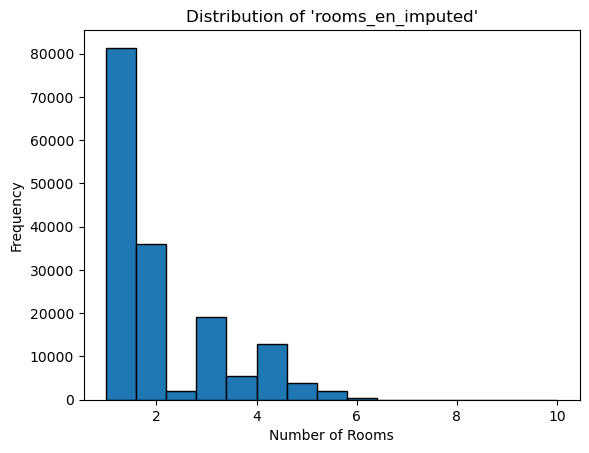

In [23]:
import numpy as np
# Step 4: Check for Missing Values
print("Missing values in 'rooms_en_imputed':", sales_data['rooms_en_imputed'].isnull().sum())
print("Unique values in 'rooms_en_imputed':", np.unique(sales_data['rooms_en_imputed']))

# Step 5: Visualize the Imputed Data
plt.hist(sales_data['rooms_en_imputed'], bins=15, edgecolor='black')
plt.title("Distribution of 'rooms_en_imputed'")
plt.xlabel("Number of Rooms")
plt.ylabel("Frequency")
plt.show()

The results indicate the following:

Mean Squared Error (MSE): A high MSE suggests the model isn't making accurate predictions, which could be due to project_name_en_encoded not having strong predictive power for amount.
R2 Score: An R² value of 0.016 suggests that the model explains only 1.6% of the variance in the target variable (amount), meaning the feature project_name_en_encoded alone is not very effective.
Feature Importance: Since the model is trained with just one feature (project_name_en_encoded), its importance is naturally 1.0. This doesn't mean it's predictive, just that it's the only feature being used
In this case, this feature could cause noise to the model. So I will fill the missing values with -1. 

In [24]:
# Reload `project_name_en` from the original dataset
sales_data['project_name_en'] = original_sales_data['project_name_en']

# Fill missing values with 'Unknown'
sales_data['project_name_en'] = sales_data['project_name_en'].fillna('Unknown')

# Confirm the operation
print(sales_data['project_name_en'].isnull().sum())  # Should print 0
print(sales_data['project_name_en'].unique()[:10])  # Sample unique values to verify


0
['THE VYBE' 'Elitz 3 By Danube ' 'TRIA BY DEYAAR' 'Oceanz 1 By Danube '
 'Club Drive' '555 PARK VIEWS' 'Creek Beach - Savanna-Cedar-Mangrove'
 'AL WALEED GARDEN 2' 'Adhara Star' 'DAMAC BAY 2']


In [25]:
# Columns to process in rentals_data
columns_to_fill_sales = ['nearest_landmark_en']

# Fill missing values with 'Unknown'
for column in columns_to_fill_sales:
    sales_data[column] = sales_data[column].fillna('Unknown')
# Columns to process in rentals_data
columns_to_fill_rentals = ['nearest_landmark_en', 'nearest_metro_en', 'nearest_mall_en']

# Fill missing values with 'Unknown'
for column in columns_to_fill_rentals:
    rentals_data[column] = rentals_data[column].fillna('Unknown')

# Verify the operation
for column in columns_to_fill_rentals:
    print(f"Missing values in '{column}': {rentals_data[column].isnull().sum()}")
    print(f"Sample unique values in '{column}': {rentals_data[column].unique()[:5]}")


Missing values in 'nearest_landmark_en': 0
Sample unique values in 'nearest_landmark_en': ['Dubai International Airport' 'Burj Al Arab' 'Burj Khalifa'
 'Downtown Dubai' 'Unknown']
Missing values in 'nearest_metro_en': 0
Sample unique values in 'nearest_metro_en': ['Al Nahda Metro Station' 'Rashidiya Metro Station'
 'Salah Al Din Metro Station' 'Sharaf Dg Metro Station'
 'Airport Free Zone']
Missing values in 'nearest_mall_en': 0
Sample unique values in 'nearest_mall_en': ['City Centre Mirdif' 'Dubai Mall' 'Mall of the Emirates' 'Marina Mall'
 'Unknown']


In [33]:
sales_data.drop(columns= meta_dup_sales, inplace=True)
rentals_data.drop(columns= meta_dup_rentals, inplace=True)

In [34]:
# Check for missing values in sales_data
print("Missing values in sales_data:")
missing_sales = sales_data.isnull().sum()
missing_sales = missing_sales[missing_sales > 0]
print(missing_sales)

# Check for missing values in rentals_data
print("\nMissing values in rentals_data:")
missing_rentals = rentals_data.isnull().sum()
missing_rentals = missing_rentals[missing_rentals > 0]
print(missing_rentals)


Missing values in sales_data:
rooms_en            23257
rooms_ar            21362
parking             40463
nearest_metro_en    65982
nearest_mall_en     66842
dtype: int64

Missing values in rentals_data:
rooms              721746
project_name_en    576935
dtype: int64


In [35]:
# Function to calculate and display missing values and percentages
def display_missing_values(data, dataset_name):
    print(f"\nMissing values in {dataset_name}:")
    missing_values = data.isnull().sum()
    missing_values = missing_values[missing_values > 0]
    missing_percentage = (missing_values / len(data)) * 100
    missing_summary = missing_values.to_frame(name='Missing Count')
    missing_summary['Percentage'] = missing_percentage
    print(missing_summary)

# Check for missing values in sales_data
display_missing_values(sales_data, 'sales_data')

# Check for missing values in rentals_data
display_missing_values(rentals_data, 'rentals_data')



Missing values in sales_data:
                  Missing Count  Percentage
rooms_en                  23257   14.285100
rooms_ar                  21362   13.121138
parking                   40463   24.853507
nearest_metro_en          65982   40.527990
nearest_mall_en           66842   41.056226

Missing values in rentals_data:
                 Missing Count  Percentage
rooms                   721746   96.566534
project_name_en         576935   77.191440


In [30]:
rentals_data['master_project_en'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 747408 entries, 0 to 747407
Series name: master_project_en
Non-Null Count  Dtype 
--------------  ----- 
97 non-null     object
dtypes: object(1)
memory usage: 5.7+ MB
